In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

import os
import cv2

import matplotlib.pyplot as plt


In [14]:
def extract_label(img_path,train = True):
    filename, _ = os.path.splitext(os.path.basename(img_path))

    subject_id, etc = filename.split('__')

    if train:
      gender, lr, finger, _, _ = etc.split('_')
    else:
      gender, lr, finger, _ = etc.split('_')

    gender = 0 if gender == 'M' else 1
    lr = 0 if lr == 'Left' else 1

    if finger == 'thumb':
      finger = 0
    elif finger == 'index':
      finger = 1
    elif finger == 'middle':
      finger = 2
    elif finger == 'ring':
      finger = 3
    elif finger == 'little':
      finger = 4
    return np.array([gender], dtype=np.uint16)

In [15]:
img_size = 96


def loading_data(path,boolean):
    data = []
    for img in os.listdir(path):
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            img_resize = cv2.resize(img_array, (img_size, img_size))
            label = extract_label(os.path.join(path, img),boolean)
            
            data.append([label[0], img_resize ])
            if len(data) % 1000 == 0:
                print(len(data))
    return data

In [16]:
Real_path = "./Real"
Easy_path = "./Altered/Altered-Easy"
Medium_path = "./Altered/Altered-Medium"
Hard_path = "./Altered/Altered-Hard"

Easy_data = loading_data(Easy_path,True)


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000


In [17]:
img, labels = [], []
for label, feature in Easy_data:
    labels.append(label)
    img.append(feature)

In [18]:
train_data = np.array(img).reshape(-1, img_size, img_size, 1)
train_data = train_data / 255.0

In [19]:
from keras.utils import to_categorical
train_labels = to_categorical(labels, num_classes = 2)

In [20]:
labels = np.array(labels)

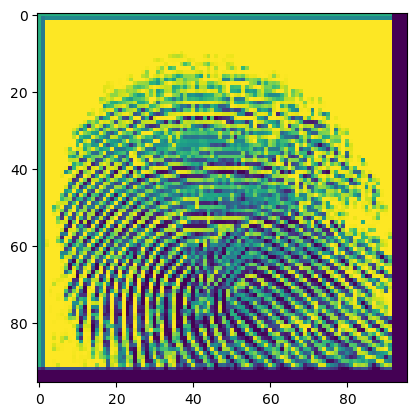

In [21]:
plt.imshow(train_data[5000])

In [22]:
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras import layers
from tensorflow.keras import optimizers

model = Sequential([
Conv2D(32, 3, padding='same', activation='relu',kernel_initializer='he_uniform', input_shape = [96, 96, 1]),
MaxPooling2D(2),
Conv2D(32, 3, padding='same', kernel_initializer='he_uniform', activation='relu'),
MaxPooling2D(2),
Flatten(),
Dense(128, kernel_initializer='he_uniform',activation = 'relu'),
Dense(1, activation = 'sigmoid'),
])
model.summary()


model.compile(optimizer = optimizers.Adam(1e-3), loss = 'binary_crossentropy', metrics = ['accuracy'])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 96, 96, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 48, 48, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 24, 24, 32)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 18432)             0         
                                                                 
 dense_2 (Dense)             (None, 128)              

In [23]:
type(labels)

numpy.ndarray

In [24]:
history = model.fit(train_data, labels, batch_size = 128, epochs = 24, 
          validation_split = 0.2, callbacks = [early_stopping_cb], verbose = 1)

Epoch 1/24


113/113 [==============================] - 83s 694ms/step - loss: 0.8911 - accuracy: 0.7848 - val_loss: 0.5275 - val_accuracy: 0.7747
Epoch 2/24
113/113 [==============================] - 67s 592ms/step - loss: 0.4323 - accuracy: 0.8090 - val_loss: 0.4786 - val_accuracy: 0.7915
Epoch 3/24
113/113 [==============================] - 63s 562ms/step - loss: 0.3695 - accuracy: 0.8337 - val_loss: 0.4892 - val_accuracy: 0.7865
Epoch 4/24
113/113 [==============================] - 64s 563ms/step - loss: 0.3044 - accuracy: 0.8691 - val_loss: 0.5791 - val_accuracy: 0.7920
Epoch 5/24
113/113 [==============================] - 64s 568ms/step - loss: 0.2362 - accuracy: 0.9054 - val_loss: 0.5947 - val_accuracy: 0.7352
Epoch 6/24
113/113 [==============================] - 66s 586ms/step - loss: 0.1638 - accuracy: 0.9405 - val_loss: 0.7145 - val_accuracy: 0.7795
Epoch 7/24
113/113 [==============================] - 63s 560ms/step - loss: 0.1025 - accuracy: 0.9683 - val_loss: 0.7670 - val_

(0.0, 1.0)

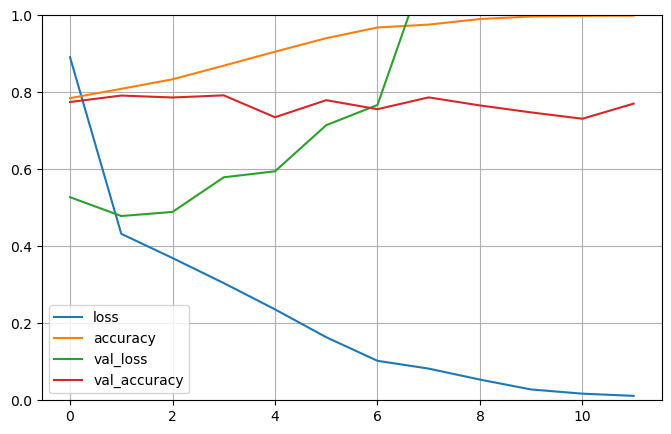

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize = (8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)

In [25]:
test_data = loading_data(Real_path,False)

x_test,y_test= [], []
for label, feature in test_data:
    y_test.append(label)
    x_test.append(feature)

1000
2000
3000
4000
5000
6000


In [26]:
x_test = np.array(x_test).reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)
type(y_test)

numpy.ndarray

In [27]:
# from keras.utils.np_utils import to_categorical
# y_test = to_categorical(y_test, num_classes = 2)

In [28]:
model.evaluate(x_test,y_test)

188/188 [==============================] - 7s 35ms/step - loss: 64.9696 - accuracy: 0.9555


[64.96956634521484, 0.9555000066757202]

188/188 [==============================] - 7s 37ms/step
6000


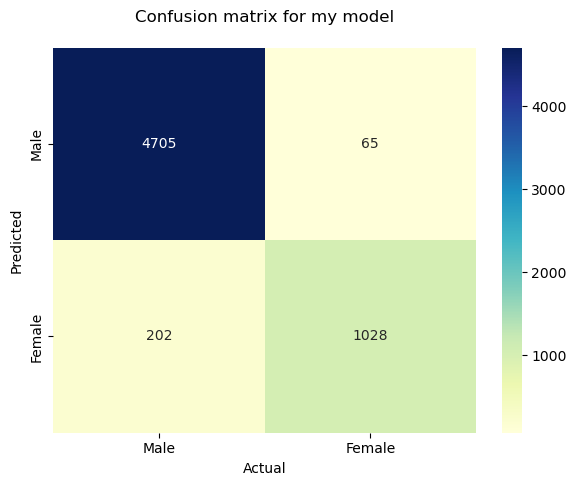

In [29]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(15, 5))

preds = model.predict(x_test)
preds = (preds >= 0.5).astype(np.int32)
cm = confusion_matrix(y_test, preds)
df_cm = pd.DataFrame(cm, index=['Male', 'Female'], columns=['Male', 'Female'])
plt.subplot(121)
plt.title("Confusion matrix for my model\n")
sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
plt.ylabel("Predicted")
plt.xlabel("Actual")

print(len(y_test==1))


In [30]:
model.save('GenderFP.h5')

C:\Users\matej\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


True:  0
1/1 [==============================] - 0s 38ms/step


predicted:  [0.]



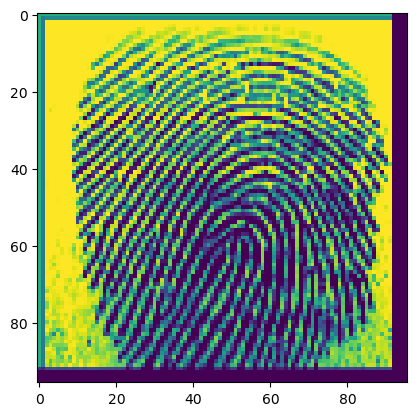

True:  0
1/1 [==============================] - 0s 40ms/step
predicted:  [0.]



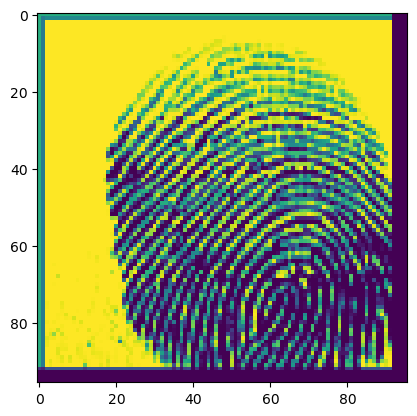

True:  0
1/1 [==============================] - 0s 35ms/step
predicted:  [0.]



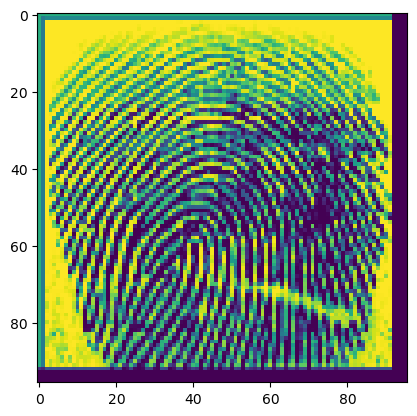

True:  0
1/1 [==============================] - 0s 41ms/step
predicted:  [0.]



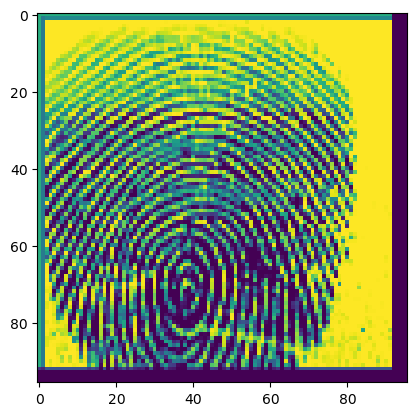

True:  0
1/1 [==============================] - 0s 32ms/step
predicted:  [0.]



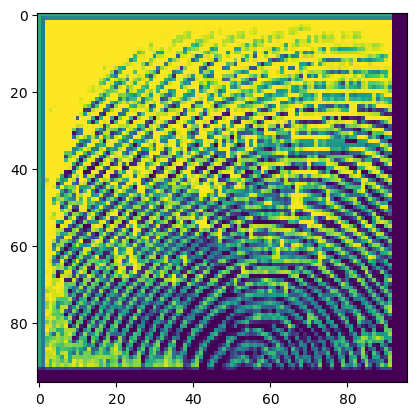

In [31]:
for i in range(5):
    print('True: ',y_test[i])
    print('predicted: ',model.predict(np.expand_dims(x_test[i],0))[0])
    print()
    plt.imshow(x_test[i])
    plt.show()